# Graph Mining - ALTEGRAD - Nov 2022
## Sicheng Mao

### part1

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [5]:
############## Task 1
G = nx.read_edgelist('../datasets/CA-HepTh.txt', comments='#', delimiter='\t')

In [6]:
print(G.number_of_nodes())
print(G.number_of_edges())

9877
25998


In [9]:
############## Task 2
largest_cc = max(nx.connected_components(G), key=len)
S = G.subgraph(largest_cc).copy()

In [13]:
print(S.number_of_nodes(), S.number_of_nodes()/G.number_of_nodes())
print(S.number_of_edges(), S.number_of_edges()/G.number_of_edges())

8638 0.8745570517363572
24827 0.9549580736979768


In [17]:
############## Task 3
# Degree
degree_sequence = [G.degree(node) for node in G.nodes()]

print(min(degree_sequence))
print(max(degree_sequence))
print(np.median(degree_sequence))
print(np.mean(degree_sequence))

1
65
3.0
5.264351523742027


In [18]:
import matplotlib.pyplot as plt

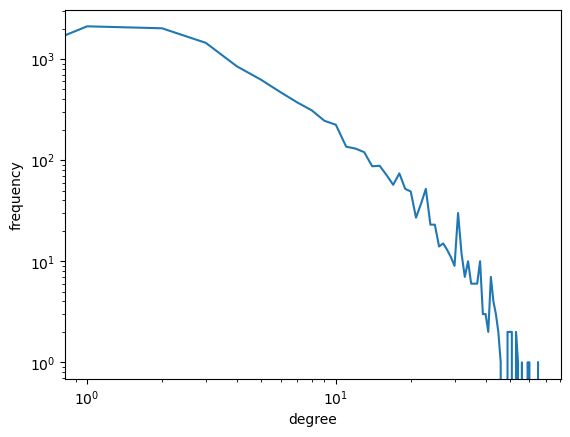

In [23]:
############## Task 4
##################
hist = nx.degree_histogram(G)
plt.xlabel('degree')
plt.ylabel('frequency')
plt.xscale('log')
plt.yscale('log')
plt.plot(hist)
##################

In [24]:
############## Task 5

##################
nx.transitivity(G)
##################

0.2839996525875546

### part2

In [25]:
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans

In [29]:
############## Task 6
# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):
    clustering = {}
    A = nx.adjacency_matrix(G)
    D_inv = diags([1/G.degree(node) for node in G.nodes()])
    L = eye(G.number_of_nodes()) - D_inv @ A
    w, U = eigs(L, k, which='SR')
    U = U.real
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(U)
    for i, node in enumerate(G.nodes()):
        clustering[node] = labels[i]
    return clustering

In [33]:
############## Task 7

##################
clustering = spectral_clustering(S, 50)
##################

In [34]:
6/13 - (11/26)**2 - (14/26)**2

-0.007396449704141939

In [74]:
############## Task 8
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):
    modularity = 0
    m = G.number_of_edges()
    labels = set(clustering.values())
    label_nodes = {label: set() for label in labels}
    for (node, label) in clustering.items():
        label_nodes[label].update({node})
    # print(label_nodes)
    for (label, nodes) in label_nodes.items():
        c = G.subgraph(nodes)
        lc = c.number_of_edges()
        dc = sum([degree for (_, degree) in c.degree()])
        modularity += lc/m - (dc /(2 * m)) ** 2

    return modularity

In [75]:
############## Task 9

##################
random_clustering = {node: randint(0,49) for node in S.nodes()}
mod = modularity(S, clustering)
mod_random = modularity(S, random_clustering)
print(mod, mod_random)
##################

0.23391396964192845 0.020210359575157415


### part3

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [77]:
############## Task 10
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()

    for i in range(3,103):
        Gs.append(nx.cycle_graph(i))
        y.append(0)
        Gs.append(nx.path_graph(i))
        y.append(1)

    return Gs, y

In [78]:
Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

In [79]:
# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

In [83]:
############## Task 11
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(Gs_train), 4))
    
    ##################
    for k, G in enumerate(Gs_train):
        for i in range(n_samples):
            s = np.random.choice(G.nodes(), 3)
            sub = G.subgraph(s)
            for i, graphlet in enumerate(graphlets):
                if nx.is_isomorphic(sub, graphlet):
                    phi_train[k, i] += 1
                    break
    ##################


    phi_test = np.zeros((len(Gs_test), 4))
    
    ##################
    for k, G in enumerate(Gs_test):
        for i in range(n_samples):
            s = np.random.choice(G.nodes(), 3)
            sub = G.subgraph(s)
            for i, graphlet in enumerate(graphlets):
                if nx.is_isomorphic(sub, graphlet):
                    phi_test[i] += 1
                    break
    ##################


    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

In [84]:
K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)

In [85]:
############## Task 12

##################
K_train_gl, K_test_gl = graphlet_kernel(G_train, G_test)
##################

In [86]:
############## Task 13

##################
clf = SVC(kernel='precomputed')
clf.fit(K_train_sp, y_train)
y_pred_sp = clf.predict(K_test_sp)
print(accuracy_score(y_test, y_pred_sp))

1.0


In [87]:
clf.fit(K_train_gl, y_train)
y_pred_gl = clf.predict(K_test_gl)
print(accuracy_score(y_test, y_pred_gl))
##################

0.65


this is quite reasonable since loop really reduce the shortest path, however add one edge up won't change dramatically the graphlet sampling. (only one edge is involved)